# Imports

In [57]:
# Import standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# API
import requests
import json
import os
# from sodapy import Socrata

# Datetime
import datetime as datetime

import snowflake.connector
# Date
import datetime as datetime
import time
from datetime import timedelta

#Math
from math import exp

In [114]:
# Gets the cursor
con = snowflake.connector.connect(
    user='meagan',
    password='Neutron123$%^',
    account='hu40871.us-east-1',
    warehouse='ANALYSIS'
    )
cur = con.cursor()

# insert query here
cur.execute('''
    SELECT  * 
    FROM    "WAREHOUSE"."GOLD"."SUBSCRIPTION_RETENTION"
           ''')

# # reads data into pandas
# df = cur.fetch_pandas_all()
# df.head()

## Acuity

In [8]:
silver = pd.read_csv('SILVER_FACT.ACUITY_ND_CONSULT_EVENTS.csv')
silver.head()

,EVENT_TS,EVENT_TS_UTC,ANONYMOUS_ID,EVENT,APPOINTMENT_BODY_CALENDAR,APPOINTMENT_BODY_FIRST_NAME,APPOINTMENT_BODY_DATETIME_CREATED,APPOINTMENT_BODY_CALENDAR_ID,APPOINTMENT_BODY_CALENDAR_TIMEZONE,EMAIL,APPOINTMENT_BODY_DATE,APPOINTMENT_BODY_DURATION,APPOINTMENT_BODY_TIMEZONE,APPOINTMENT_DATE_TIME,APPOINTMENT_BODY_LAST_NAME,APPOINTMENT_BODY_TYPE,APPOINTMENT_BODY_ID,APPOINTMENT_TYPE_ID,APPOINTMENT_BODY_CANCELED,APPOINTMENT_BODY_NO_SHOW
0,2020-12-23 23:45:03.646,2020-12-24 07:45:03.646,495876669,appointment_scheduled,"Dr. Anya Arthen, ND",Hunter,2020-12-24 01:45:00.000,3513713.0,America/New_York,hunterelliott510@gmail.com,"December 29, 2020",20.0,America/Los_Angeles,2020-12-29 14:25:00.000,Elliott,Hair Consultation,495876669.0,12047150.0,False,NaN
1,2021-01-03 00:03:41.860,2021-01-03 08:03:41.860,499867827,appointment_scheduled,"Dr. Nicole Klughers, ND",Kathleen,2021-01-03 02:03:40.000,3513704.0,America/New_York,katmc@sbcglobal.net,"January 21, 2021",20.0,America/Los_Angeles,2021-01-21 17:00:00.000,McElhinney,Hair Consultation,499867827.0,12799707.0,False,NaN
2,2020-12-27 21:34:32.762,2020-12-28 05:34:32.762,496859072,appointment_scheduled,"Dr. Nadia Musavvir, ND",ashley,2020-12-27 23:34:29.000,3513708.0,America/Chicago,ashleynizzle@yahoo.com,"January 6, 2021",20.0,America/Chicago,2021-01-06 12:30:00.000,patkovic,Hair Consultation,496859072.0,12799707.0,False,NaN
3,2020-11-27 03:05:47.644,2020-11-27 11:05:47.644,481523073,appointment_scheduled,"Dr. Ariana Zastrow, ND",Rose,2020-11-27 05:05:44.000,3684820.0,America/New_York,foxbody1986@hotmail.com,"December 7, 2020",20.0,America/New_York,2020-12-07 16:55:00.000,DeLaRosa,Hair Consultation,481523073.0,12047150.0,False,NaN
4,2020-12-08 03:30:31.906,2020-12-08 11:30:31.906,487457386,appointment_scheduled,"Dr. Ariana Zastrow, ND",Anita,2020-12-08 05:30:28.000,3684820.0,America/New_York,anbavitz@gmail.com,"December 22, 2020",20.0,America/New_York,2020-12-22 12:25:00.000,Bavitz,Hair Consultation,487457386.0,12047150.0,False,NaN


In [100]:
# Create a copy of the dataframe to preserve the content of the API export during cleaning
silver_acuity = silver.copy()
silver_acuity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18257 entries, 0 to 18256
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   EVENT_TS                            18257 non-null  object 
 1   EVENT_TS_UTC                        18257 non-null  object 
 2   ANONYMOUS_ID                        18257 non-null  int64  
 3   EVENT                               18257 non-null  object 
 4   APPOINTMENT_BODY_CALENDAR           17979 non-null  object 
 5   APPOINTMENT_BODY_FIRST_NAME         17979 non-null  object 
 6   APPOINTMENT_BODY_DATETIME_CREATED   17979 non-null  object 
 7   APPOINTMENT_BODY_CALENDAR_ID        17979 non-null  float64
 8   APPOINTMENT_BODY_CALENDAR_TIMEZONE  17979 non-null  object 
 9   EMAIL                               17921 non-null  object 
 10  APPOINTMENT_BODY_DATE               17979 non-null  object 
 11  APPOINTMENT_BODY_DURATION           17979

In [101]:
# Change dates to datetime Dtype
silver_acuity['APPOINTMENT_BODY_DATE'] = pd.to_datetime(silver_acuity['APPOINTMENT_BODY_DATE'])
# silver_acuity.columns

# Drop unneeded columns
silver_acuity.drop(columns=['EVENT_TS', 'EVENT_TS_UTC', 'ANONYMOUS_ID','APPOINTMENT_BODY_FIRST_NAME',
       'APPOINTMENT_BODY_DATETIME_CREATED', 'APPOINTMENT_BODY_CALENDAR_ID','APPOINTMENT_BODY_CALENDAR_TIMEZONE',\
                    'APPOINTMENT_BODY_TIMEZONE', 'APPOINTMENT_BODY_LAST_NAME', 'APPOINTMENT_BODY_ID',\
                    'APPOINTMENT_BODY_NO_SHOW', \
                    'APPOINTMENT_TYPE_ID'], inplace=True)

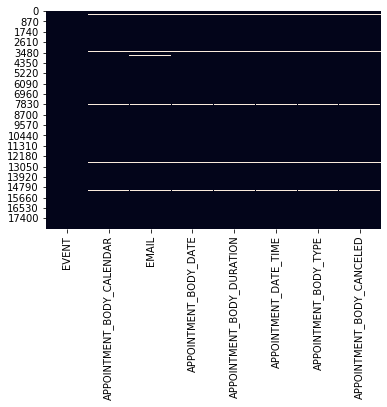

In [102]:
# Check for null values
sns.heatmap(silver_acuity.isnull(), cbar=False)

In [103]:
silver_acuity['EVENT'].value_counts()

appointment_changed        13582
appointment_scheduled       3838
appointment_rescheduled      516
appointment_canceled         321
Name: EVENT, dtype: int64

In [104]:
# drop irrelevant appointments

na_dict= {'appointment_canceled' : np.nan,
'appointment_changed' : np.nan,
'appointment_rescheduled' : np.nan}

silver_acuity['EVENT'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['EVENT'].value_counts()

appointment_scheduled    3729
Name: EVENT, dtype: int64

In [105]:
#Round to the day
silver_acuity['APPOINTMENT_BODY_DATE'] = silver_acuity['APPOINTMENT_BODY_DATE']

In [106]:
#Round to the day
silver_acuity['APPOINTMENT_BODY_DATE'] = silver_acuity['APPOINTMENT_BODY_DATE'].dt.round('D')

# Group by precinct 
chart = silver_acuity.groupby(["APPOINTMENT_BODY_DATE"]).agg({'EVENT':'count'})
chart.isna().sum()

EVENT    0
dtype: int64

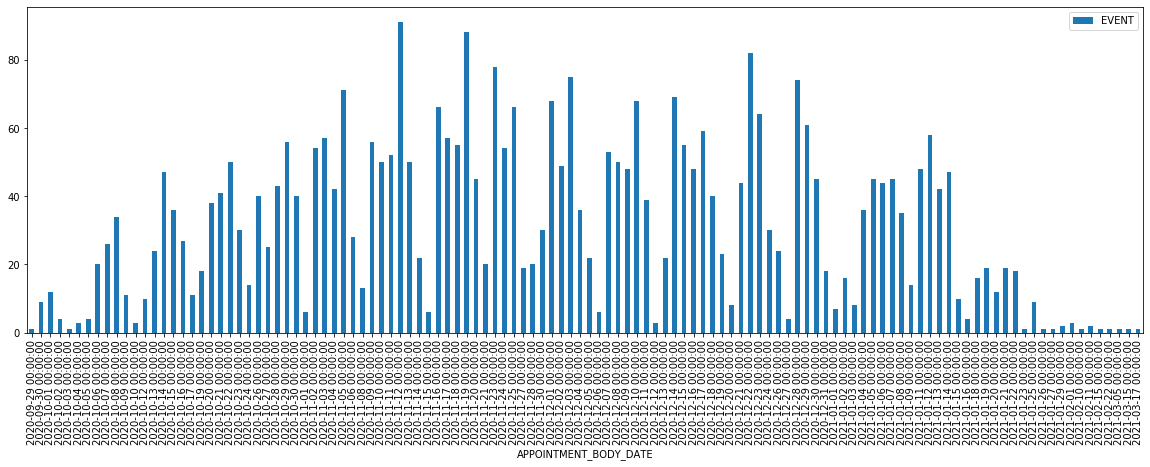

In [107]:
chart.plot(kind='bar',figsize=(20,6))

timeseries_df.Fine_Amount.plot(figsize = (20,5))
plt.title("Fine Amount", size= 24)
plt.show()

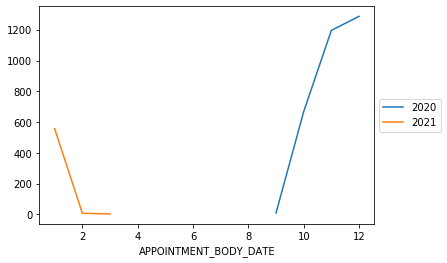

In [117]:
(silver_acuity.groupby([silver_acuity['APPOINTMENT_BODY_DATE'].dt.month,\
                       silver_acuity['APPOINTMENT_BODY_DATE'].dt.year])\
 ['EVENT'].count()).unstack().plot(kind='line')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [112]:
min(silver_acuity['APPOINTMENT_BODY_DATE'])

Timestamp('2020-09-29 00:00:00')

In [111]:
max(silver_acuity['APPOINTMENT_BODY_DATE'])

Timestamp('2021-03-17 00:00:00')

In [49]:
# Rearrange columns for easier data visualization

# violation_df = violation_df[[ 'Plate','time_issued', 'Fine_Amount', 'Amount_Due', 'Payment_Amount',
#        'Precinct', 'County', 'State']]
# violation_df.head()

# Rename counties to be more recognizable

# violation_df.rename(columns={'County_BX':'Bronx', 'County_K':'Brooklyn', \
#                              'County_NY':'Manhattan', 'County_Q':'Queens', \
#                              'County_R':'Staten_Island'}, inplace=True)

In [50]:
# Rename Precint column
# violation_df.rename(columns={'Precinct':'precinct'}, inplace=True)
# violation_df.head()

# Remove null values
# zero_dict = {0: np.nan}
# violation_df['precinct'].replace(zero_dict, inplace = True)
# violation_df.dropna(inplace = True)

In [ ]:
# import pyvenv
# import snowflake.connector as snow
# from snowflake.connector.pandas_tools import write_pandas
# import pyarrow

# # Gets the version
# conn = snow.connect(
#     user='meagan',
#     password='Neutron123$%^',
#     account='hu40871.us-east-1',
#     warehouse="ANALYSIS",
#     database="WAREHOUSE",
# #     schema="SUBSCRIPTION_RETENTION"
#     )
# cur = conn.cursor()
# print(conn)

# cur.execute("SHOW DATABASES")

# for db in cur:
#     print(db)

# Execute a statement that will generate a result set WAREHOUSE.GOLD.SUBSCRIPTION_RETENTION
# sql = "select * from GOLD.SUBSCRIPTION_RETENTION"
# cur.execute(sql)

In [26]:
# Export data
# violation_df.to_csv('Tickets_Data.csv')